In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm import tqdm

In [29]:
class MultiKernelConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 5, 7]):
        super(MultiKernelConv2d, self).__init__()
        self.branches = nn.ModuleList()
        for kernel_size in kernel_sizes:
            branch = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(2, 2)
            )
            self.branches.append(branch)

    def forward(self, x):
        outputs = []
        for branch in self.branches:
            outputs.append(branch(x))
        return torch.cat(outputs, 1)

class CNN(nn.Module):
    def __init__(self, n_classes, img_size):
        super(CNN, self).__init__()
        self.conv1 = MultiKernelConv2d(1, 3)
        self.conv2 = MultiKernelConv2d(9, 3)
        self.fc1 = nn.Linear(3 * 3 * (img_size // 4) * (img_size // 4), 2048)
        self.fc2 = nn.Linear(2048, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ApplyMask(nn.Module):
    def __init__(self):
        super(ApplyMask, self).__init__()

    def forward(self, logits, x):
        neighbors = torch.roll(x, shifts=1, dims=2) + \
                    torch.roll(x, shifts=-1, dims=2) + \
                    torch.roll(x, shifts=1, dims=3) + \
                    torch.roll(x, shifts=-1, dims=3)
        mask = ((neighbors > 0) & (x == 0)).reshape(logits.shape)
        masked_logits = torch.where(mask, logits, torch.tensor(-1e9))
        return masked_logits

class CNNWithMask(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(CNNWithMask, self).__init__()
        self.unet = CNN(n_channels, n_classes)
        self.apply_mask = ApplyMask()

    def forward(self, x):
        logits = self.unet(x)
        masked_logits = self.apply_mask(logits, x)
        return masked_logits

model = CNNWithMask(150*150, 150)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
print(model)

CNNWithMask(
  (unet): CNN(
    (conv1): MultiKernelConv2d(
      (branches): ModuleList(
        (0): Sequential(
          (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (1): Sequential(
          (0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (2): Sequential(
          (0): Conv2d(1, 3, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
          (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, 

In [25]:
X = []
y = []

for idx, file in tqdm(enumerate(os.listdir('../data'))):
    if file.endswith('.parquet'):
        df = pd.read_parquet(f'../data/{file}')
        X_tmp = df.to_numpy()
        y_tmp = X_tmp[1:] - X_tmp[:-1]
        X_tmp = X_tmp[:-1].reshape(-1, 1, 150, 150)
        random_idx = np.random.choice(X_tmp.shape[0], 10)
        X.extend(X_tmp[random_idx])
        y.extend(y_tmp[random_idx])
    if idx == 100:
        break
    
X = torch.tensor(np.array(X), dtype=torch.float32)
y = torch.tensor(np.array(y), dtype=torch.float32)
    
print(X.shape, y.shape)

100it [02:38,  1.59s/it]


torch.Size([1010, 1, 150, 150]) torch.Size([1010, 22500])


In [30]:
model.train();

batch_size = 10
for i in range(0, len(X), batch_size):
    X_batch = X[i:i+batch_size]
    y_batch = y[i:i+batch_size]
    output = model(X_batch)
    loss = criterion(output, y_batch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(loss.item())

6.068746089935303
8.349120140075684
12.775327682495117
17.918411254882812
8.634108543395996
11.225261688232422
10.37977409362793
10.607215881347656
-99899998208.0
11.344000816345215
11.340108871459961
20.054994583129883
18.55240249633789
24.466169357299805
13.190816879272461
21.795812606811523
23.53915023803711
28.526931762695312
22.938434600830078
28.975971221923828
22.178024291992188
25.91519546508789
22.548782348632812
23.716907501220703
17.65529441833496
20.334972381591797
22.3404483795166
17.710460662841797
17.196285247802734
19.531200408935547
12.320028305053711
13.41339111328125
14.293670654296875
14.401331901550293
11.647645950317383
11.052518844604492
9.011894226074219
7.409736633300781
7.660633087158203
5.849284648895264
7.715096950531006
6.307800769805908
6.39795446395874
6.2132368087768555
6.614997863769531
5.8547468185424805
6.147298812866211
6.129153251647949
5.654195308685303
5.890031337738037
5.958530902862549
6.343392848968506
5.718908309936523
6.083386421203613
5.3285

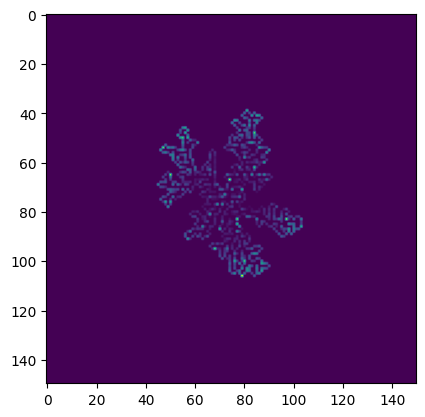

In [31]:
model.eval()

output = F.softmax(model(X[:1]), dim=1)
output = output.detach().numpy().reshape(150, 150)
plt.imshow(output);